# Notebook de nettoyage
## Adrian Rodriguez
## Projet 4 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [1]:
import pandas as pd
pd.options.display.max_columns = None

import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

from bs4 import BeautifulSoup
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import PIL.Image
import en_core_web_sm

pd.options.display.max_columns = None
plt.style.use("default")
nlp = en_core_web_sm.load()

from functions import *

---
# 1. Importation et exploration préliminaire
Les données ont été extraite du site stackexchangeexplorer. J'ai traité des post récents.    
Requête SQL :      
SELECT TOP 1000 *    
FROM posts    
ORDER BY CreationDate DESC

Les données ont été stockées dans le fichiser 'QueryResults.csv'.

In [2]:
stack_raw = pd.read_csv('src/Posts_QueryResults.csv')

In [3]:
stack_raw.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,63433501,2,NaN,63431603.0,2020-08-16 05:35:04,NaN,0,NaN,<p>To be able to push view controller onto the...,5443937,NaN,NaN,NaN,NaN,2020-08-16 05:35:04,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0
1,63433499,2,NaN,63416894.0,2020-08-16 05:35:03,NaN,0,NaN,<p>If you use <code>PairGrid</code> instead of...,1356000,NaN,NaN,NaN,NaN,2020-08-16 05:35:03,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0
2,63433500,1,NaN,NaN,2020-08-16 05:35:03,NaN,0,1.0,"<p>The shape of my test_data is (418, 13).\nT...",14112861,NaN,NaN,NaN,NaN,2020-08-16 05:35:03,How to reduce the dimension of data frame?,<python><pandas><dataframe><machine-learning><...,0.0,0,NaN,NaN,NaN,CC BY-SA 4.0
3,63433498,1,NaN,NaN,2020-08-16 05:34:42,NaN,0,2.0,<p>in my views I defined the paginator functio...,13097857,NaN,NaN,NaN,NaN,2020-08-16 05:34:42,How can I fix this paginator problem in python,<python><django><post><pagination><blogs>,0.0,0,NaN,NaN,NaN,CC BY-SA 4.0
4,63433497,1,NaN,NaN,2020-08-16 05:34:42,NaN,0,2.0,<p>I am trying to dynamically add <strong>acti...,14112866,NaN,NaN,NaN,NaN,2020-08-16 05:34:42,Dynamically add active to menu using javascript,<javascript><php><html><jquery>,0.0,0,NaN,NaN,NaN,CC BY-SA 4.0


In [4]:
stack_raw.shape

(1000, 23)

In [5]:
stack_raw.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')

In [6]:
stack_raw.isna().sum()

Id                          0
PostTypeId                  0
AcceptedAnswerId          970
ParentId                  487
CreationDate                0
DeletionDate             1000
Score                       0
ViewCount                 513
Body                        0
OwnerUserId                 0
OwnerDisplayName         1000
LastEditorUserId          799
LastEditorDisplayName    1000
LastEditDate              799
LastActivityDate            0
Title                     513
Tags                      513
AnswerCount               513
CommentCount                0
FavoriteCount             977
ClosedDate                961
CommunityOwnedDate        999
ContentLicense              0
dtype: int64

In [7]:
stack = stack_raw.copy()

# 2. Exploration préliminaire
## Identification des types de posts

In [8]:
stack.PostTypeId.value_counts()

2    513
1    487
Name: PostTypeId, dtype: int64

In [9]:
stack[stack.Tags.notna()][['PostTypeId', 'ParentId']].isna().sum()

PostTypeId      0
ParentId      487
dtype: int64

Losque l'on créé un nouveau sujet, l'utilisateur doit indiquer un titre et des tags correpondant à son sujet. Si un post ne contient ni titre, ni tags, alors il s'agit d'un post de réponse à une question.   
De ce fait, si `PostTypeId` = 1 ou si `ParentId` est manquant, alors il s'agit d'un post de question, un post où je dois suggérer des tags à l'utilisateur final.

In [10]:
questions = stack[stack.PostTypeId == 1]

## Activité des utilisateurs finaux du site

In [11]:
stack.CreationDate = pd.to_datetime(stack.CreationDate, format="%Y-%m-%d %H:%M:%S")
delta = stack.CreationDate.max() - stack.CreationDate.min()
delay_post = round(delta.total_seconds() / len(stack), 0)
delay_question = round(delta.total_seconds() / len(questions), 0)
print(f'Le site Stackoverflow recoit un post, que ce soit en question ou en réponse aux questions, toutes les {delay_post} secondes et une nouvelle question toutes les {delay_question} secondes')

Le site Stackoverflow recoit un post, que ce soit en question ou en réponse aux questions, toutes les 13.0 secondes et une nouvelle question toutes les 27.0 secondes


## Taux de réponse à une question

In [12]:
no_response = round(questions.AnswerCount.value_counts().loc[0] / len(questions) * 100, 0)
print(f'{no_response} % des questions posées ne trouvent aucune réponse')

72.0 % des questions posées ne trouvent aucune réponse


# 3. Exploration des tags associés aux questions
JE cherche à connaître quels sont les tags les plus utilisés et à savoir

In [13]:
columns = ['Id', 'Title', 'Body', 'Tags']
questions = questions[columns]
questions.head()

,Id,Title,Body,Tags
2,63433500,How to reduce the dimension of data frame?,"<p>The shape of my test_data is (418, 13).\nT...",<python><pandas><dataframe><machine-learning><...
3,63433498,How can I fix this paginator problem in python,<p>in my views I defined the paginator functio...,<python><django><post><pagination><blogs>
4,63433497,Dynamically add active to menu using javascript,<p>I am trying to dynamically add <strong>acti...,<javascript><php><html><jquery>
5,63433496,Find text between two json keys using regex,<p>I have a json text file which contains keys...,<python><python-3.x><regex><regex-greedy><re>
7,63433494,Django Rest Framework - customize default list...,<p>My models are bound with multiple fields us...,<django><django-models><django-rest-framework>


In [14]:
questions.Tags = questions.Tags.apply(lambda x: x.replace('<', '').replace('>', ' ')).str.split()
tags = questions.Tags.explode().reset_index()
tags = tags.groupby('Tags').count().sort_values(by='index', ascending=False).reset_index()
print(f'Nous avons {len(tags)} tags utilisés sur la période')

Nous avons 710 tags utilisés sur la période


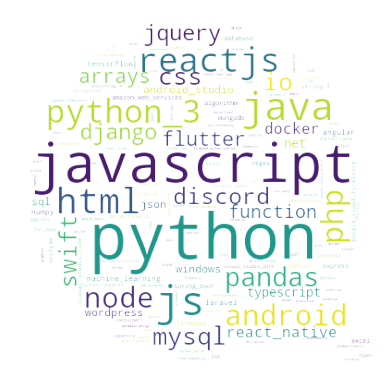

In [15]:
tags.Tags = tags.Tags.str.replace('-', '_')
text = (tags.Tags + ' ') * tags['index']
text = ''.join(text)

# Création de l'objet
mask = np.array(PIL.Image.open('src/bulle.jpg'))
wordcloud = WordCloud(width=1200, height=780, background_color="rgba(255, 255, 255, 0)", mode="RGBA", collocations=False, mask=mask).generate(text)
 
# Génération de l'image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

plt.savefig('img/img_wordcloud_tags.png',
            transparent=True,
            bbox_inches="tight")

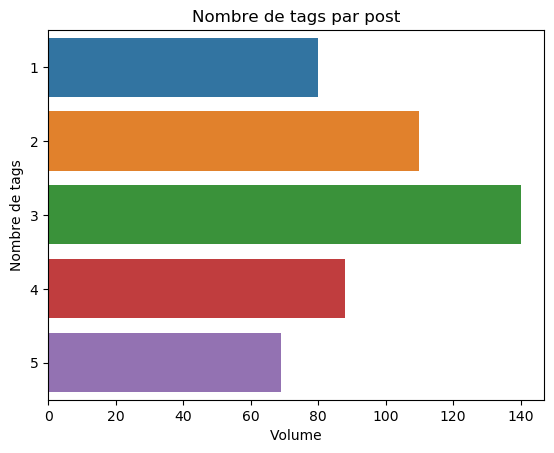

In [16]:
tags_count = questions.Tags.apply(lambda x: len(x)).reset_index()
tags_count = tags_count.groupby('Tags').count().reset_index()

plt.clf()
sns.barplot(y='Tags',
            x='index',
            data=tags_count,
            orient='h')
plt.title('Nombre de tags par post')
plt.xlabel('Volume')
plt.ylabel('Nombre de tags')

plt.savefig('img/img_tags_count.png',
            transparent=True,
            bbox_inches="tight")

# 4. NLP Preprocessing

## Nettoyage et lemmatisation

En procédant à un test maison, je me rends facilement compte que je peux mettre des informations importante soit dans le titre, soit dans le body. Je ne pense pas forcément à les mettre dans les 2 blocs. De ce fait, je dois analyser le champs `Body` et le champs `Title`.

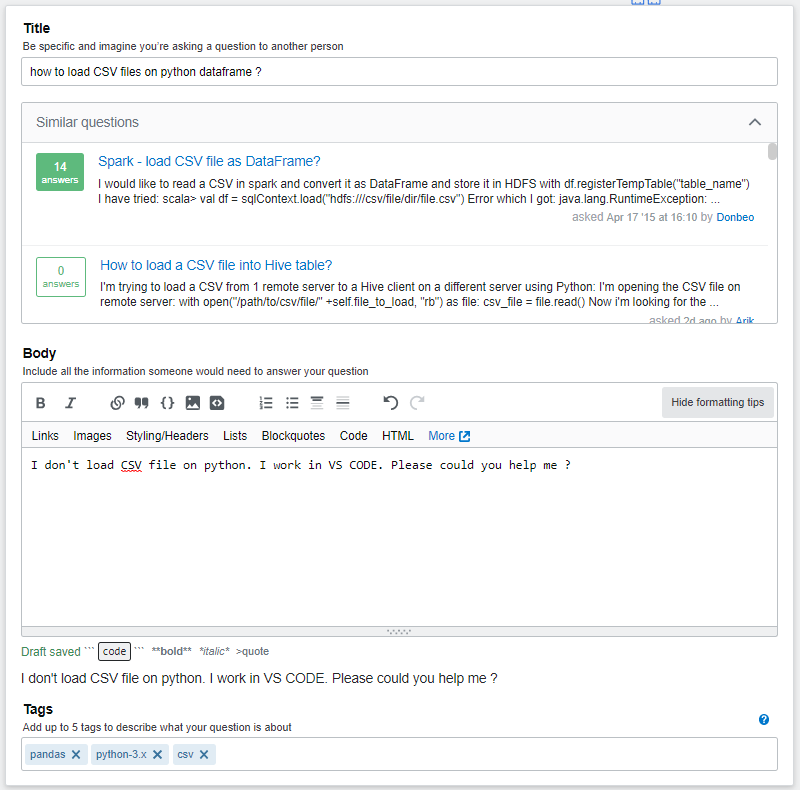

In [17]:
Image('src/post.png')

In [18]:
questions['Title_Body'] = questions.Title + ' ' + questions.Body
questions

,Id,Title,Body,Tags,Title_Body
2,63433500,How to reduce the dimension of data frame?,"<p>The shape of my test_data is (418, 13).\nT...","[python, pandas, dataframe, machine-learning, ...",How to reduce the dimension of data frame? <p>...
3,63433498,How can I fix this paginator problem in python,<p>in my views I defined the paginator functio...,"[python, django, post, pagination, blogs]",How can I fix this paginator problem in python...
4,63433497,Dynamically add active to menu using javascript,<p>I am trying to dynamically add <strong>acti...,"[javascript, php, html, jquery]",Dynamically add active to menu using javascrip...
5,63433496,Find text between two json keys using regex,<p>I have a json text file which contains keys...,"[python, python-3.x, regex, regex-greedy, re]",Find text between two json keys using regex <p...
7,63433494,Django Rest Framework - customize default list...,<p>My models are bound with multiple fields us...,"[django, django-models, django-rest-framework]",Django Rest Framework - customize default list...
...,...,...,...,...,...
986,63432452,While loop iteration issue in C,<p>Hey so I'm experiencing a small error in my...,"[c, while-loop]",While loop iteration issue in C <p>Hey so I'm ...
987,63432451,how to get nested scrapy - selectors,<p>How can I get the xpath of 'img src' of the...,"[python-3.x, scrapy]",how to get nested scrapy - selectors <p>How ca...
990,63432448,How Can I Serialize a Derived Class whose base...,<p>I have a simple program which represents a ...,"[c#, .net, serialization]",How Can I Serialize a Derived Class whose base...
995,63432442,Can CI/CD actions be triggered by Bitbucket PR...,<p>I am trying to implement slash commands whi...,"[continuous-integration, bitbucket, devops, bi...",Can CI/CD actions be triggered by Bitbucket PR...


Lorsque j'analyse une quesion. Je constate qu'il peut y avoir des blocs de codes, et des blocs d'image. Ces blocs génèrent du bruit et n'apporte pas de ou très peu de valeurs ajouté au sens de la question. Je décide de les retirer. Les blocs de code non préformaté ne peuvent pas être retiré  
Je retire également les tags HTML, les retours ligne \n, les éventuels caractères accentués et je passe tous les caractères en minuscule s'il ne le sont pas déjà.

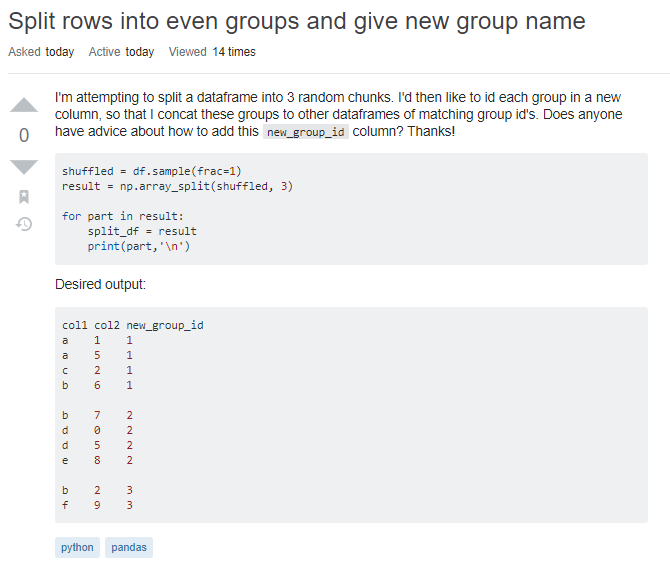

In [19]:
Image('src/question.png')

In [20]:
# Je retire les bloc de code préformatté et les bloc image
questions.Title_Body = questions.Title_Body.apply(lambda x: extract_preformattext_imageurl(x))
# Je retire les tags HTML
questions.Title_Body = questions.Title_Body.apply(lambda x: strip_html_tags(x))
# Je retire les retours ligne \n
questions.Title_Body = questions.Title_Body.apply(lambda x: x.replace('\n', ''))
# Je retire les éventuels caractères accentués
questions.Title_Body = questions.Title_Body.apply(lambda x: remove_accented_chars(x))
# Je passe tous les caractères en minuscule
questions.Title_Body = questions.Title_Body.apply(lambda x: x.lower())

questions.Title_Body.head(20)

2     how to reduce the dimension of data frame?  th...
3     how can i fix this paginator problem in python...
4     dynamically add active to menu using javascrip...
5     find text between two json keys using regex  i...
7     django rest framework - customize default list...
11    can you secretly run a python file?  i couldn'...
12    the first function doesn't recognizes the new ...
15    display javascript object in webpage without k...
19    why can't i pass in a functor with a mutex to ...
20    how to use scikit-optimization for bayesian op...
27    when using on_member_join, how do i get the me...
30    assets file obj\project.assets.json doesn't ha...
31    how to post button value to label field using ...
34    how to save text using sharedpreferences on dr...
38    can anyone suggest me some beginner friendly p...
40    django cms, there is a piece of html in the in...
42    why is the time stamp not used for conflict re...
52    unable to launch jupyter notebook from a n

In [21]:
questions['Lemma_Title_Body'] = questions.Title_Body.apply(lambda x: remove_stopwords_PRON(x, nlp))
questions.Lemma_Title_Body

2      reduce dimension datum frame shape shape perfo...
3      fix paginator problem python view define pagin...
4      dynamically add active menu use javascript try...
5      find text json key use regex json text file co...
7      django rest framework customize default list v...
                             ...                        
986    loop iteration issue c hey experience small er...
987       nest scrapy selector xpath img src follow html
990    serialize derive class base serializable simpl...
995    ci cd action trigger bitbucket pr comment try ...
996    openshift online clojure mkdir create director...
Name: Lemma_Title_Body, Length: 487, dtype: object

In [22]:
tokens = token_text(' '.join(questions.Lemma_Title_Body), nlp)
Counter(tokens).most_common(10)

[('use', 491),
 ('try', 302),
 ('code', 301),
 ('file', 221),
 ('work', 214),
 ('error', 184),
 ('want', 172),
 ('create', 160),
 ('like', 159),
 ('run', 143)]

In [23]:
questions['Lemma_Title_Body'] = questions.Lemma_Title_Body.apply(lambda x: remove_verbs_adj(x, nlp))
questions['Lemma_Title_Body']

2      dimension datum frame shape shape perform foll...
3      fix paginator problem python view define pagin...
4      dynamically menu use javascript dynamically me...
5      text json key use regex json text file text te...
7      django rest framework customize default list v...
                             ...                        
986    loop iteration issue c hey error c program cau...
987       nest scrapy selector xpath img src follow html
990    class base program represent contact list peop...
995    ci cd action trigger bitbucket pr comment impl...
996    openshift online clojure mkdir directory permi...
Name: Lemma_Title_Body, Length: 487, dtype: object

In [24]:
tokens = token_text(' '.join(questions.Lemma_Title_Body), nlp)
Counter(tokens).most_common(10)

[('use', 322),
 ('code', 297),
 ('file', 215),
 ('work', 192),
 ('error', 184),
 ('like', 159),
 ('c', 139),
 ('function', 136),
 ('datum', 131),
 ('value', 127)]

## Vectorisation

In [25]:
X_train, X_test, y_train, y_test = train_test_split(questions.Lemma_Title_Body, questions.Tags, test_size=0.2, random_state=123)

In [26]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [27]:
vectorizer = CountVectorizer()
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)
# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

print(f'Dimension X_train_bow : {X_train_bow.shape}')
print(f'Dimension X_test_bow : {X_test_bow.shape}')

print(f'Le vecteur bag of word contient {X_train_bow.shape[1]} mots')

Dimension X_train_bow : (389, 2406)
Dimension X_test_bow : (98, 2406)
Le vecteur bag of word contient 2406 mots


## Classification multilabel

In [28]:
mlb = MultiLabelBinarizer()
# Reprise des tags originaux et test de inverse_transform
y_test = mlb.fit_transform(y_test)
y_test_inversed = mlb.inverse_transform(y_test)

# Mise en place la classification supervisée multilabel
y_train = mlb.fit_transform(y_train)

In [29]:
classifier = [('LogisticRegression', LogisticRegression(C=1, penalty='l1', dual=False, solver='liblinear')),
              ('LinearSVC', LinearSVC(C=1, penalty='l1', dual=False, loss='squared_hinge')), 
              ('MultinomialNB', MultinomialNB(alpha=1.0)),
              ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(solver='svd'))]

for clf_name, clf in classifier:
    print(f'Classification avec {clf_name}...\n')
    
    model = OneVsRestClassifier(clf)
    if clf_name == 'LinearDiscriminantAnalysis':
        model.fit(np.array(X_train_bow), y_train)
    else: 
        model.fit(X_train_bow, y_train)

    y_pred = model.predict(X_test_bow)

    y_pred_inversed = mlb.inverse_transform(y_pred)

    # Comparaison des résultats
    for i in range(5):
        print(f'{X_test[i]}\n\nTags originaux: {y_test_inversed[i]}\nTags prédits: {y_pred_inversed[i]}\n\n')
    
    print('##################################################\n\n')

Classification avec LogisticRegression...

medium stream multiple container design vision project evaluate design use container module like capture video container like dag video audio stream use container use case video time stream system learning model sink save learning model container image stream container socket container pass stream use container contain zeromq brokerless pipeline use pub sub model share volume option machine like performance utilization mem cpu

Tags originaux: ('audio-streaming', 'containers', 'microsoft-edge', 'video-streaming')
Tags prédits: ('remote-access', 'ssh', 'visual-studio')


django pagination page twice database update background work webpage image car source store database display infinite webpage user site page load scroll javascript page scroll page database update background image database use code server moment database update user scroll page reason page user scroll page page track image page image base specify filter view function

Tags orig

ValueError: setting an array element with a sequence.